# BlindDeconvolution

We try to solve the following problem:

$$
arg \;  min_\mathbf{X} \frac{1}{2}||\mathbf{y}-\mathbf{BX}||_2^2 + \mu ||\mathbf{x}||_1 + \delta_{0\le\mathbf{b}\le1} 
$$

or 

$$
arg \;  min_\mathbf{X} \frac{1}{2}||\mathbf{y}-\mathbf{BX}||_2^2 + \delta_{||\mathbf{x}||_1\le\alpha} + \delta_{0\le\mathbf{b}\le1} 
$$

or 

$$
arg \;  min_\mathbf{X} \frac{1}{2}||\mathbf{y}-\mathbf{BX}||_2^2 + \delta_{||\mathbf{x}||_0\le\alpha} + \delta_{0\le\mathbf{b}\le1} 
$$

In [18]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy import misc
from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *
from pylops.utils.wavelets import *
from pylops.utils.signalprocessing import convmtx

from pyproximal.proximal import *
from pyproximal.utils.bilinear import BilinearOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.palm import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
class BlindDec(BilinearOperator):
    def __init__(self, x, y, d):
        self.nx = x.size
        self.ny = y.size
        
        self.x = x
        self.y = y
        self.d = d
        self.X = convmtx(x, self.nx)[self.ny//2:self.nx+self.ny//2, :self.ny]
        self.Y = convmtx(self.y, self.nx)[self.ny//2:self.nx+self.ny//2]
        self.shapex = (self.nx, self.nx)
        self.shapey = (self.nx, self.ny)

    def __call__(self, x, y):
        xold = self.x.copy()
        self.updatex(x)
        res = self.d - self._matvecy(y)
        self.updatex(xold)
        
        return np.linalg.norm(res)**2 / 2.

    def _matvecx(self, x):
        Y = convmtx(self.y, self.nx)[self.ny//2:self.nx+self.ny//2]
        b = Y @ x
        return b

    def _matvecy(self, y):
        X = convmtx(self.x, self.nx)[self.ny//2:self.nx+self.ny//2, :self.ny]
        b = X @ y
        return b

    def _rmatvecx(self, x):
        Y = convmtx(self.y, self.nx)[self.ny//2:self.nx+self.ny//2]
        b = np.conj(Y.T) @ x
        return b

    def _rmatvecy(self, y):
        X = convmtx(self.x, self.nx)[self.ny//2:self.nx+self.ny//2, :self.ny]
        b = np.conj(X.T) @ y
        return b
    
    def matvec(self, x):
        if x.size == self.shapex[1]:
            y = self._matvecx(x)
        else:
            y = self._matvecy(x)
        return y
    
    def rmatvec(self, d, xupd=True):
        if xupd:
            x = self._rmatvecx(d)
        else:
            x = self._rmatvecy(d)
        return x
    
    def lx(self, x):
        X = convmtx(x, self.nx)[self.ny//2:self.nx+self.ny//2, :self.ny]
        lx = np.linalg.norm(np.conj(X).T @ X, 'fro') + 1e-10
        return lx

    def ly(self, y):
        Y = convmtx(y, self.nx)[self.ny//2:self.nx+self.ny//2]
        ly = np.linalg.norm(np.conj(Y).T @ Y, 'fro') + 1e-10
        return ly
    
    def gradx(self, x):
        r = self.d - self.matvec(x)
        g = -self.rmatvec(r, True)
        return g

    def grady(self, y):
        r = self.d - self.matvec(y)
        g = -self.rmatvec(r, False)
        return g
    
    def grad(self, x_or_y):
        pass

    def updatex(self, x):
        """Update x variable (used when evaluating the gradient over y
        """
        self.x = x

    def updatey(self, y):
        """Update y variable (used when evaluating the gradient over y
        """
        self.y = y

Convolution operator <63x63 Convolve1D with dtype=float32>


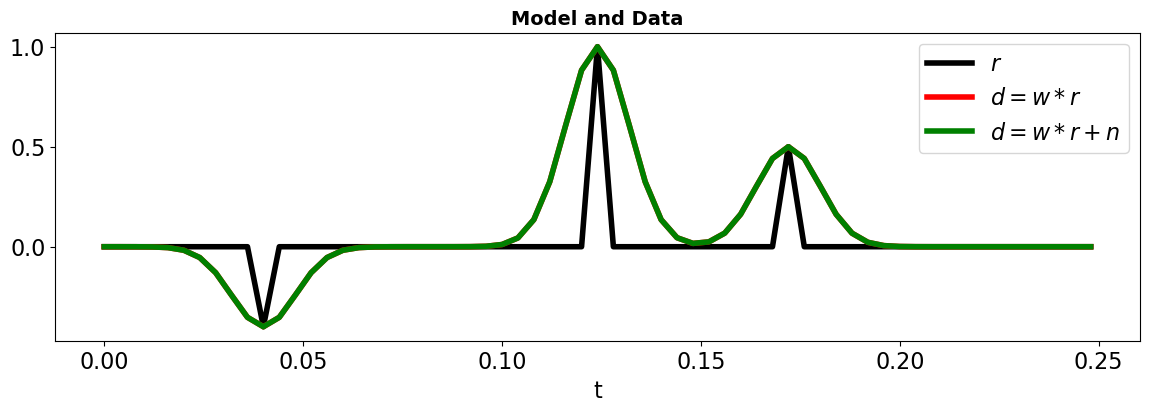

In [20]:
# Model
nt = 63 # this needs to be a odd number to ensure symmetric wavelet in the frequency domain approach
dt = 0.004

t = np.arange(nt) * dt
x = np.zeros(nt)
x[10] = -0.4
x[int(nt / 2)] = 1
x[nt - 20] = 0.5

# Operator
#h, th, hcenter = ricker(t[:21], 20)
h, th, hcenter = gaussian(t[:21], 2)
nh = h.size
Cop = Convolve1D(nt, h=h, offset=hcenter, dtype="float32")
print('Convolution operator', Cop)

# Data
sigma = 0. #1e-2
y = Cop * x
yn = y + np.random.normal(0., sigma, nt)

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=4, label=r"$r$")
ax.plot(t, y, "r", lw=4, label=r"$d=w*r$")
ax.plot(t, yn, "g", lw=4, label=r"$d=w*r+n$")
ax.set_xlabel("t")
ax.set_title("Model and Data", fontsize=14, fontweight="bold")
ax.legend();

For now we need to rely on dense Toeplitz matrices (as our operator does not handle filters larger than inputs)

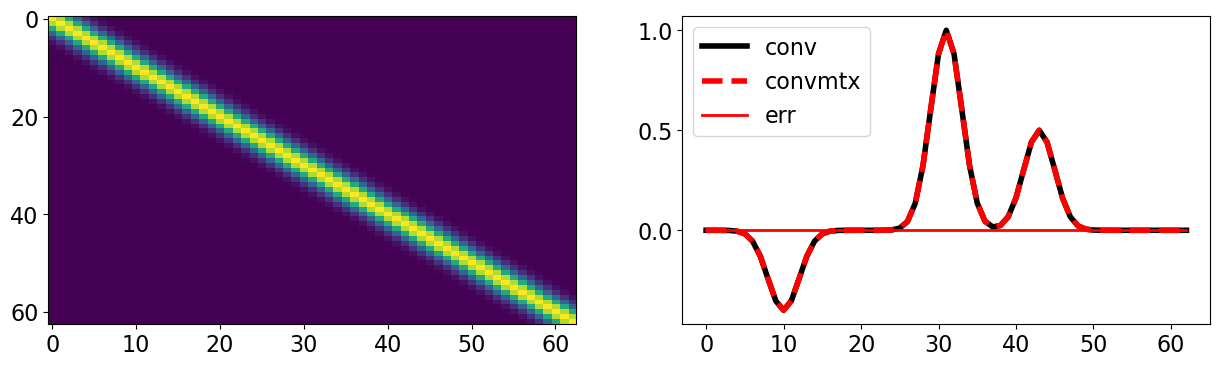

In [21]:
C = convmtx(h, nt)[hcenter:nt + hcenter]
Copdense = MatrixMult(C)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].imshow(C)
axs[0].axis('tight')
axs[1].plot(y, 'k', lw=4, label="conv")
axs[1].plot(Copdense * x, '--r', lw=4, label="convmtx")
axs[1].plot(y-Copdense * x, 'r', lw=2, label="err")
axs[1].legend();

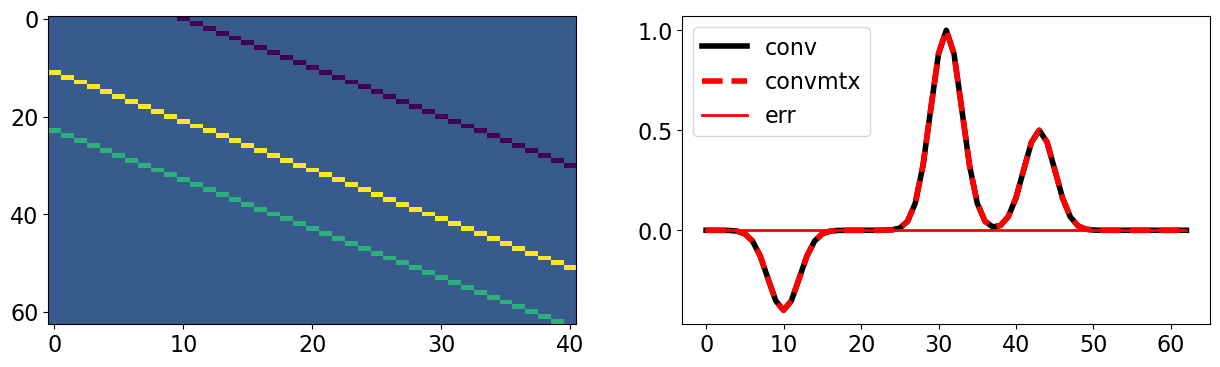

In [22]:
X = convmtx(x, nt)[hcenter:nt+hcenter, :nh]
Xopdense = MatrixMult(X)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].imshow(X)
axs[0].axis('tight')
axs[1].plot(y, 'k', lw=4, label="conv")
axs[1].plot(Xopdense * h, '--r', lw=4, label="convmtx")
axs[1].plot(y-Xopdense * h, 'r', lw=2, label="err")
axs[1].legend();

Testing the operator

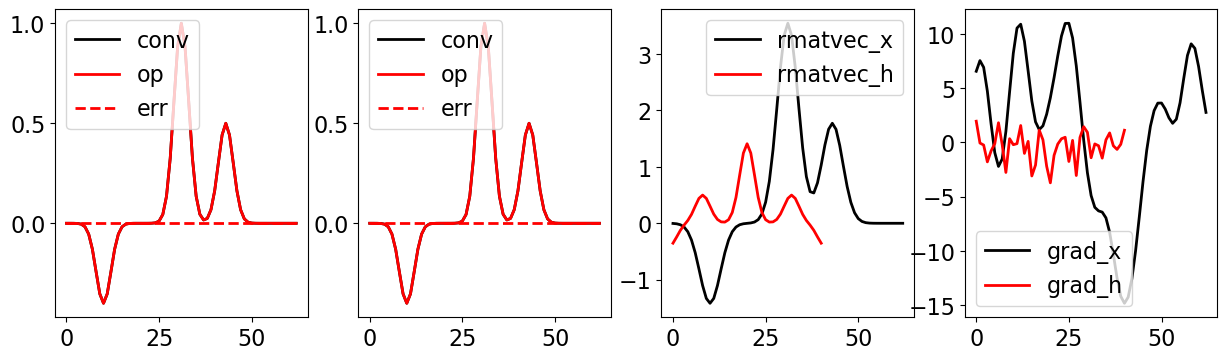

In [23]:
bdec = BlindDec(x, h, y.copy())

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

# matvec
axs[0].plot(y, 'k', lw=2, label="conv")
axs[0].plot(bdec.matvec(x), 'r', lw=2, label="op")
axs[0].plot(y-bdec.matvec(x), '--r', lw=2, label="err")
axs[0].legend()

axs[1].plot(y, 'k', lw=2, label="conv")
axs[1].plot(bdec.matvec(h), 'r', lw=2, label="op")
axs[1].plot(y-bdec.matvec(h), '--r', lw=2, label="err")
axs[1].legend()

# rmatvec
axs[2].plot(bdec.rmatvec(y, True), 'k', lw=2, label="rmatvec_x")
axs[2].plot(bdec.rmatvec(y, False), 'r', lw=2, label="rmatvec_h")
axs[2].legend()

# gradient
axs[3].plot(bdec.gradx(np.random.normal(0, 1, x.size)), 'k', lw=2, label="grad_x")
axs[3].plot(bdec.grady(np.random.normal(0, 1, h.size)), 'r', lw=2, label="grad_h")
axs[3].legend();

Let's now solve the problem with a soft-contraint for x and a hard-constrain for b

PALM algorithm
---------------------------------------------------------
Bilinear operator: <class '__main__.BlindDec'>
Proximal operator (f): <class 'pyproximal.proximal.L1.L1'>
Proximal operator (g): <class 'pyproximal.proximal.Box.Box'>
gammaf = 0.5	gammag = 100.0	niter = 5000

   Itn      x[0]       y[0]        f         g         H         ck         dk
     1  6.44871e-01  1.84e-04  2.05e+00  0.00e+00  1.06e+01  5.60e+01  7.14e+03
     2  6.39592e-01  3.09e-04  2.00e+00  0.00e+00  6.77e+00  5.60e+01  6.76e+03
     3  6.34529e-01  3.88e-04  1.96e+00  0.00e+00  5.10e+00  5.60e+01  6.52e+03
     4  6.28333e-01  4.35e-04  1.92e+00  0.00e+00  4.03e+00  5.60e+01  6.36e+03
     5  6.20880e-01  4.59e-04  1.89e+00  0.00e+00  3.27e+00  5.60e+01  6.23e+03
     6  6.12634e-01  4.70e-04  1.87e+00  0.00e+00  2.70e+00  5.60e+01  6.13e+03
     7  6.03898e-01  4.73e-04  1.84e+00  0.00e+00  2.27e+00  5.60e+01  6.04e+03
     8  5.94847e-01  4.70e-04  1.82e+00  0.00e+00  1.94e+00  5.60e+01  5.97e+03

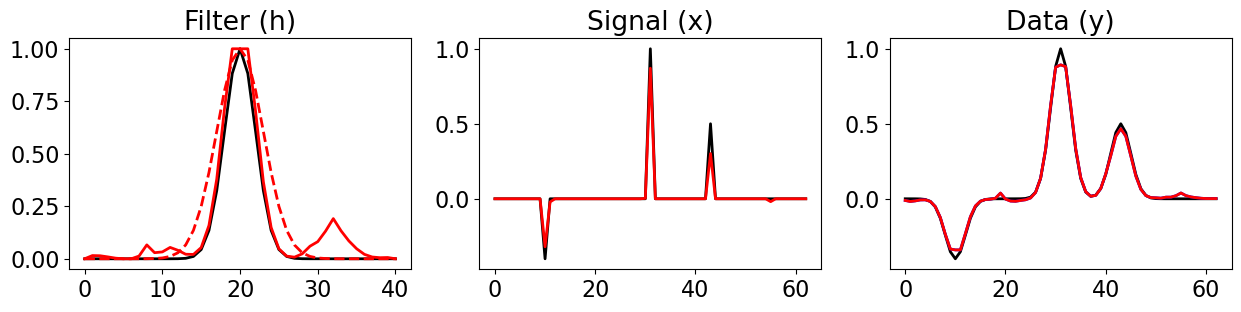

In [24]:
np.random.seed(10)
cx = L1(sigma=1e-1)
ch = Box(lower=0, upper=1) # gaussian
#ch = Box(lower=-.5, upper=1) # ricker

xin = np.random.normal(0., 0.5, nt)#np.zeros(nt)
hin = gaussian(t[:21], 3)[0]
Cop = BlindDec(xin, hin, y)
gammaf=.5
gammag=100.

xest, hest = PALM(Cop, cx, ch, xin, hin, gammaf=gammaf, gammag=gammag, niter=5000, show=True)

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
axs[0].plot(h, 'k', lw=2, label="true")
axs[0].plot(hin, '--r', lw=2, label="init")
axs[0].plot(hest, 'r', lw=2, label="est")
axs[0].set_title('Filter (h)')

axs[1].plot(x, 'k', lw=2, label="true")
axs[1].plot(xest, 'r', lw=2, label="est")
axs[1].set_title('Signal (x)')

axs[2].plot(y, 'k', lw=2, label="true")
axs[2].plot(Cop.matvec(xest), 'b', lw=2, label="mod with xest")
axs[2].plot(Cop.matvec(hest), 'r', lw=2, label="mod with hest")
axs[2].set_title('Data (y)');

Or with a L1 hard-constrain for x too

PALM algorithm
---------------------------------------------------------
Bilinear operator: <class '__main__.BlindDec'>
Proximal operator (f): <class 'pyproximal.proximal.L1.L1Ball'>
Proximal operator (g): <class 'pyproximal.proximal.Box.Box'>
gammaf = 0.5	gammag = 100.0	niter = 5000

   Itn      x[0]       y[0]        f         g         H         ck         dk
     1  2.68207e-02  0.00e+00  1.00e+00  0.00e+00  2.99e+00  5.60e+01  4.72e+02
     2  7.12304e-03  0.00e+00  0.00e+00  0.00e+00  2.07e+00  5.60e+01  3.78e+02
     3  0.00000e+00  0.00e+00  1.00e+00  0.00e+00  1.55e+00  5.60e+01  3.19e+02
     4  0.00000e+00  0.00e+00  1.00e+00  0.00e+00  1.24e+00  5.61e+01  2.75e+02
     5  0.00000e+00  0.00e+00  1.00e+00  0.00e+00  1.02e+00  5.61e+01  2.44e+02
     6  0.00000e+00  0.00e+00  1.00e+00  0.00e+00  8.61e-01  5.62e+01  2.23e+02
     7  0.00000e+00  0.00e+00  1.00e+00  0.00e+00  7.41e-01  5.62e+01  2.10e+02
     8  0.00000e+00  0.00e+00  1.00e+00  0.00e+00  6.50e-01  5.62e+01  2.02

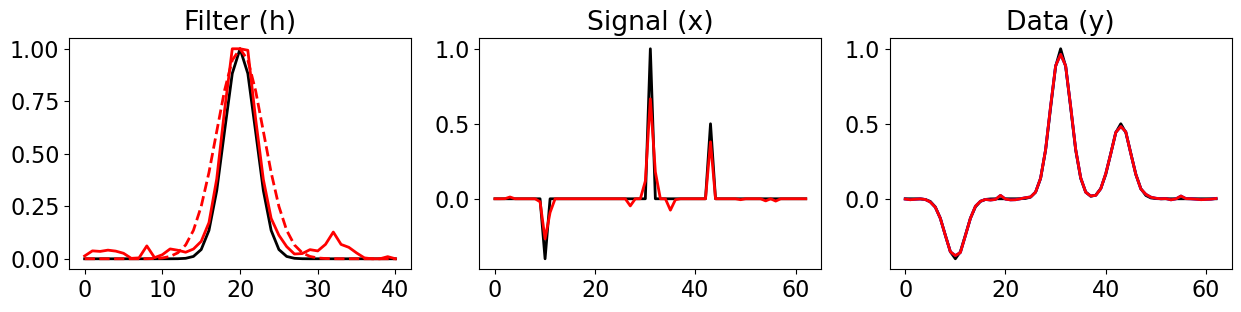

In [25]:
np.random.seed(10)
cx = L1Ball(nt, np.abs(x).sum())
ch = Box(lower=0, upper=1) # gaussian
#ch = Box(lower=-.5, upper=1) # ricker

xin = np.random.normal(0., 0.5, nt)#np.zeros(nt)
hin = gaussian(t[:21], 3)[0]
Cop = BlindDec(xin, hin, y)
gammaf=.5
gammag=100.

xest, hest = PALM(Cop, cx, ch, xin, hin, gammaf=gammaf, gammag=gammag, 
                  niter=5000, show=True)

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
axs[0].plot(h, 'k', lw=2, label="true")
axs[0].plot(hin, '--r', lw=2, label="init")
axs[0].plot(hest, 'r', lw=2, label="est")
axs[0].set_title('Filter (h)')

axs[1].plot(x, 'k', lw=2, label="true")
axs[1].plot(xest, 'r', lw=2, label="est")
axs[1].set_title('Signal (x)')

axs[2].plot(y, 'k', lw=2, label="true")
axs[2].plot(Cop.matvec(xest), 'b', lw=2, label="mod with xest")
axs[2].plot(Cop.matvec(hest), 'r', lw=2, label="mod with hest")
axs[2].set_title('Data (y)');

Or with a L0 hard-constrain for x too

PALM algorithm
---------------------------------------------------------
Bilinear operator: <class '__main__.BlindDec'>
Proximal operator (f): <class 'pyproximal.proximal.L0.L0Ball'>
Proximal operator (g): <class 'pyproximal.proximal.Box.Box'>
gammaf = 1.0	gammag = 100.0	niter = 5000

   Itn      x[0]       y[0]        f         g         H         ck         dk
     1  0.00000e+00  2.39e-05  1.00e+00  0.00e+00  4.95e+00  2.21e+01  1.95e+03
     2  0.00000e+00  4.95e-05  1.00e+00  0.00e+00  4.59e+00  2.20e+01  1.67e+03
     3  0.00000e+00  7.70e-05  1.00e+00  0.00e+00  4.28e+00  2.20e+01  1.43e+03
     4  0.00000e+00  1.06e-04  1.00e+00  0.00e+00  4.01e+00  2.19e+01  1.23e+03
     5  0.00000e+00  1.38e-04  1.00e+00  0.00e+00  3.79e+00  2.19e+01  1.05e+03
     6  0.00000e+00  1.72e-04  1.00e+00  0.00e+00  3.60e+00  2.18e+01  9.05e+02
     7  0.00000e+00  2.08e-04  1.00e+00  0.00e+00  3.43e+00  2.17e+01  7.78e+02
     8  0.00000e+00  2.46e-04  1.00e+00  0.00e+00  3.30e+00  2.17e+01  6.68

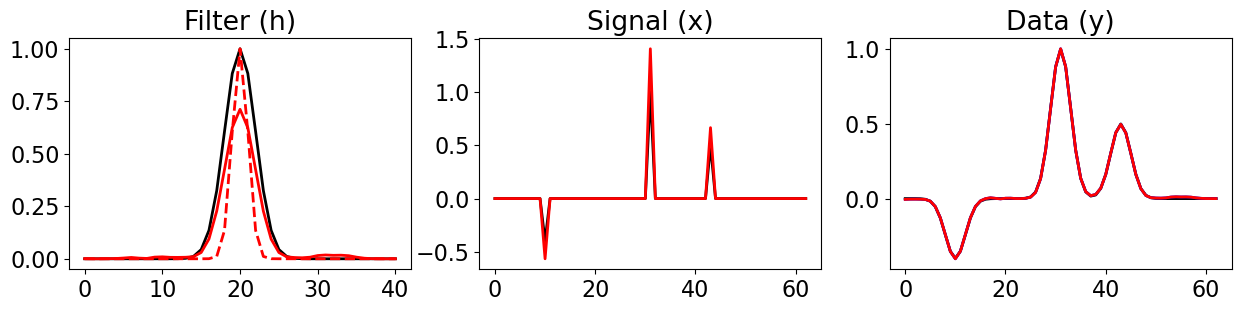

In [26]:
np.random.seed(10)
cx = L0Ball(3)
ch = Box(lower=0, upper=1) # gaussian
#ch = Box(lower=-.5, upper=1) # ricker

xin = np.random.normal(0., 0.5, nt)#np.zeros(nt)
hin = gaussian(t[:21], 1.)[0]
Cop = BlindDec(xin, hin, y)
gammaf=1.
gammag=100.

xest, hest = PALM(Cop, cx, ch, xin, hin, gammaf=gammaf, gammag=gammag, 
                  niter=5000, show=True)

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
axs[0].plot(h, 'k', lw=2, label="true")
axs[0].plot(hin, '--r', lw=2, label="init")
axs[0].plot(hest, 'r', lw=2, label="est")
axs[0].set_title('Filter (h)')

axs[1].plot(x, 'k', lw=2, label="true")
axs[1].plot(xest, 'r', lw=2, label="est")
axs[1].set_title('Signal (x)')

axs[2].plot(y, 'k', lw=2, label="true")
axs[2].plot(Cop.matvec(xest), 'b', lw=2, label="mod with xest")
axs[2].plot(Cop.matvec(hest), 'r', lw=2, label="mod with hest")
axs[2].set_title('Data (y)');